In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pickle
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
import xgboost as xgb
from itertools import product
import math

#import shap



# Data

In [27]:
data = pd.read_csv('2023_DS2_HW1_data_train.csv', sep = ',', decimal = '.', index_col = 'Booking_ID')

In [28]:
data

no_of_adults  no_of_children  no_of_weekend_nights  \
Booking_ID                                                       
INN10204             NaN             NaN                   NaN   
INN20020             NaN             NaN                   NaN   
INN16435             1.0             NaN                   NaN   
INN07143             3.0             NaN                   NaN   
INN20511             1.0             0.0                   1.0   
...                  ...             ...                   ...   
INN16851             2.0             NaN                   NaN   
INN06266             1.0             NaN                   NaN   
INN11285             2.0             NaN                   NaN   
INN00861             2.0             NaN                   NaN   
INN15796             2.0             NaN                   NaN   

            no_of_week_nights type_of_meal_plan  required_car_parking_space  \
Booking_ID                                                                    
INN10204                  2.0       Meal Plan 2                         NaN   
INN20020                  2.0       Meal Plan 1                         NaN   
INN16435                  2.0               NaN                         0.0   
INN07143                  3.0               NaN                         NaN   
INN20511                  1.0       Meal Plan 1                         0.0   
...                       ...               ...                         ...   
INN16851                  NaN       Meal Plan 1                         NaN   
INN06266                  2.0       Meal Plan 2                         0.0   
INN11285                  2.0               NaN                         NaN   
INN00861                  3.0       Meal Plan 1                         0.0   
INN15796                  2.0               NaN                         NaN   

           room_type_reserved  lead_time  arrival_year  arrival_month  \
Booking_ID                                                              
INN10204          Room_Type 6        NaN        2018.0            9.0   
INN20020                  NaN        NaN           NaN           12.0   
INN16435          Room_Type 1        NaN        2018.0           11.0   
INN07143                  NaN      100.0        2018.0            5.0   
INN20511                  NaN        NaN        2018.0           11.0   
...                       ...        ...           ...            ...   
INN16851                  NaN       43.0        2017.0           12.0   
INN06266          Room_Type 1      102.0        2017.0           10.0   
INN11285                  NaN        NaN        2018.0            5.0   
INN00861                  NaN        NaN        2018.0            6.0   
INN15796                  NaN       14.0        2018.0            9.0   

            arrival_date market_segment_type  repeated_guest  \
Booking_ID                                                     
INN10204             NaN              Online             0.0   
INN20020             NaN              Online             0.0   
INN16435             NaN                 NaN             0.0   
INN07143             NaN              Online             0.0   
INN20511             NaN                 NaN             0.0   
...                  ...                 ...             ...   
INN16851            26.0             Offline             NaN   
INN06266             NaN              Online             NaN   
INN11285             NaN           Corporate             0.0   
INN00861             NaN              Online             NaN   
INN15796            15.0              Online             NaN   

            no_of_previous_cancellations  \
Booking_ID                                 
INN10204                             0.0   
INN20020                             0.0   
INN16435                             0.0   
INN07143                             0.0   
INN20511                             0.0   
...                               

In [29]:
# define list of predictors
cols_pred = list(data.columns[0:-1])
# define list of numerical predictors
cols_pred_num = [col for col in cols_pred if data[col].dtype != 'O']
# define list of categorical predictors
cols_pred_cat = [col for col in cols_pred if data[col].dtype == 'O']
col_target = "booking_status"

Booking_ID: unique identifier of each booking
no_of_adults: Number of adults
no_of_children: Number of Children
no_of_weekend_nights: Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel
no_of_week_nights: Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel
type_of_meal_plan: Type of meal plan booked by the customer:
required_car_parking_space: Does the customer require a car parking space? (0 - No, 1- Yes)
room_type_reserved: Type of room reserved by the customer. The values are ciphered (encoded) by INN Hotels.
lead_time: Number of days between the date of booking and the arrival date
arrival_year: Year of arrival date
arrival_month: Month of arrival date
arrival_date: Date of the month
market_segment_type: Market segment designation.
repeated_guest: Is the customer a repeated guest? (0 - No, 1- Yes)
no_of_previous_cancellations: Number of previous bookings that were canceled by the customer prior to the current booking
no_of_previous_bookings_not_canceled: Number of previous bookings not canceled by the customer prior to the current booking
avg_price_per_room: Average price per day of the reservation; prices of the rooms are dynamic. (in euros)
no_of_special_requests: Total number of special requests made by the customer (e.g. high floor, view from the room, etc)
booking_status: Flag indicating if the booking was canceled or not.

In [30]:
cols_pred_num

#arrival date stejne vyhodim, ale arrival month by mel byt numericky
#ostatni promenny jsou bud skutecne numericky nebo 0-1

['no_of_adults',
 'no_of_children',
 'no_of_weekend_nights',
 'no_of_week_nights',
 'required_car_parking_space',
 'lead_time',
 'arrival_year',
 'arrival_month',
 'arrival_date',
 'repeated_guest',
 'no_of_previous_cancellations',
 'no_of_previous_bookings_not_canceled',
 'avg_price_per_room',
 'no_of_special_requests']

In [31]:
cols_pred_num.remove('arrival_month')
cols_pred_cat.append('arrival_month')

In [32]:
#vyhodim data, pro ktera neznam target
data = data.dropna(subset=['booking_status'])
data.booking_status.value_counts(dropna=False)

0.0    21774
1.0    10521
Name: booking_status, dtype: int64

In [33]:
#split dat

#kdybychom chteli stratifikovat podle neceho dalsiho, museli bychom zlikvidovat unavailable data, coz je skoda.
#zaroven stratifikace podle booking status asi trochu pomaha - soude z grafu nize
data_train, data_rest = train_test_split(data, test_size=0.4, random_state = 12,stratify = (data[["booking_status"]]))
data.loc[data_train.index, 'sample'] = 'train'
# use train_test_split to split the rest into valid and test (don't forget seed); use stratification
data_valid, data_test = train_test_split(data_rest, test_size=0.5, random_state = 12, stratify = (data_rest[["booking_status"]]))
data.loc[data_valid.index, 'sample'] = 'valid'
data.loc[data_test.index, 'sample'] = 'test'

/var/folders/qt/9ghf87fd40589wf9l6s3w6680000gn/T/ipykernel_32636/1525022515.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[data_train.index, 'sample'] = 'train'


In [34]:
train_mask = (data['sample'] == 'train')
valid_mask = (data['sample'] == 'valid')
test_mask = (data['sample'] == 'test')

In [35]:
# pro vyrobu grafu nize
def default_rate_in_time_per_sample(dt, col_target, col_month, col_sample):
    # group by over month and sample
    dt_grp = dt.groupby([col_month, col_sample]).agg(
        def_rt = (col_target, np.mean)
    ).reset_index()
    
    # pivot sample values to columns
    dt_grp_pivot = dt_grp.pivot(index = col_month, columns = col_sample, values = 'def_rt')

    # plot default rate in time
    lines = plt.plot(range(len(dt_grp_pivot)), dt_grp_pivot, marker = 'o')
    plt.xticks(range(len(dt_grp_pivot)), dt_grp_pivot.index, rotation = 90)
    # set legend
    plt.legend(iter(lines), tuple(dt_grp_pivot.columns), loc='best', bbox_to_anchor=(1.05, 1))
    
    plt.ylim([0, 1])
    plt.ylabel('default rate')
    plt.xlabel('month')
    plt.show()

InvalidIndexError: (slice(None, None, None), None)

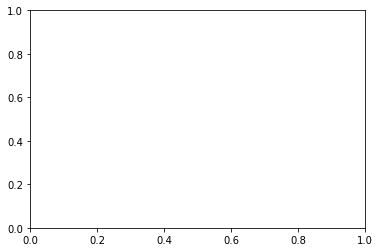

In [36]:
col_target = "booking_status"

default_rate_in_time_per_sample(data,col_target, 'arrival_month','sample')

# categorical variables encoding

In [37]:
def mean_target_encoding(dt, predictor, target, alpha = 0.01):
    total_cnt = len(dt)
    total_dr = np.mean(dt[target])
    dt_grp = dt.groupby(predictor).agg(
        categ_dr = (target, np.mean),
        categ_cnt = (target, len)
    )
    
    dt_grp['categ_freq'] = dt_grp['categ_cnt'] / total_cnt
    dt_grp['categ_encoding'] = (dt_grp['categ_freq'] * dt_grp['categ_dr'] + alpha * total_dr) / (dt_grp['categ_freq'] + alpha)
    
    return dt_grp[['categ_encoding']].to_dict()['categ_encoding']

In [38]:
total_dr = np.mean(data[train_mask][col_target])

# encode categorical predictors
for pred in tqdm(cols_pred_cat):
    if len(data[pred].unique()) < 5:
        dummies = pd.get_dummies(
            data[pred], 
            prefix = pred,
            prefix_sep = '_',
            dummy_na = True if data[pred].isnull().sum() > 0 else False,
            drop_first = False
        )
        
        for d in dummies.columns:
            if d in data.columns:
                del data[d]
                
        data = data.join(dummies)
        
        for col in dummies.columns:
            if col not in cols_pred:
                cols_pred.append(col)
        
        if pred in cols_pred:
            cols_pred.remove(pred)
    else:
        new_vals = mean_target_encoding(
            dt=data[train_mask], 
            predictor=pred, 
            target=col_target
        )

        additional_values = set(data[data[pred].notnull()][pred].unique()) - set(new_vals.keys())
        for p in additional_values:
            new_vals[p] = total_dr

        data['MTE_' + pred] = data[pred].replace(new_vals)
        
        if 'MTE_' + pred not in cols_pred:
            cols_pred.append('MTE_' + pred)
        
        if pred in cols_pred:
            cols_pred.remove(pred)

  0%|          | 0/4 [00:00<?, ?it/s]

/var/folders/qt/9ghf87fd40589wf9l6s3w6680000gn/T/ipykernel_32636/2915958815.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['MTE_' + pred] = data[pred].replace(new_vals)
/var/folders/qt/9ghf87fd40589wf9l6s3w6680000gn/T/ipykernel_32636/2915958815.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['MTE_' + pred] = data[pred].replace(new_vals)
/var/folders/qt/9ghf87fd40589wf9l6s3w6680000gn/T/ipykernel_32636/2915958815.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

# Model

In [39]:
# prvni jednoduchy model, abychom tutsili, co je dulezite
params = {    
    'max_depth': 4,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
}

evals_result = {}
booster = xgb.train(
    params = params,
    dtrain = xgb.DMatrix(data[train_mask][cols_pred], data[train_mask][col_target]),
    num_boost_round = 1000,
    evals = (
        (xgb.DMatrix(data[train_mask][cols_pred], data[train_mask][col_target]), 'train'),
        (xgb.DMatrix(data[test_mask][cols_pred], data[test_mask][col_target]), 'test'),
        (xgb.DMatrix(data[valid_mask][cols_pred], data[valid_mask][col_target]), 'valid')
    ),
    evals_result = evals_result,
    early_stopping_rounds = 10
)

[0]	train-auc:0.72523	test-auc:0.71854	valid-auc:0.72905
[1]	train-auc:0.75338	test-auc:0.74916	valid-auc:0.75798
[2]	train-auc:0.76536	test-auc:0.75953	valid-auc:0.76856
[3]	train-auc:0.77015	test-auc:0.76651	valid-auc:0.77599
[4]	train-auc:0.77514	test-auc:0.76908	valid-auc:0.77767
[5]	train-auc:0.77966	test-auc:0.77244	valid-auc:0.78309
[6]	train-auc:0.78500	test-auc:0.77547	valid-auc:0.78812
[7]	train-auc:0.78745	test-auc:0.77635	valid-auc:0.78857
[8]	train-auc:0.79051	test-auc:0.77945	valid-auc:0.79216
[9]	train-auc:0.79380	test-auc:0.78304	valid-auc:0.79312
[10]	train-auc:0.79532	test-auc:0.78478	valid-auc:0.79476
[11]	train-auc:0.79807	test-auc:0.78502	valid-auc:0.79627
[12]	train-auc:0.79988	test-auc:0.78557	valid-auc:0.79666
[13]	train-auc:0.80174	test-auc:0.78798	valid-auc:0.79880
[14]	train-auc:0.80237	test-auc:0.78862	valid-auc:0.79939
[15]	train-auc:0.80378	test-auc:0.79068	valid-auc:0.79991
[16]	train-auc:0.80549	test-auc:0.79150	valid-auc:0.80037
[17]	train-auc:0.80605	t

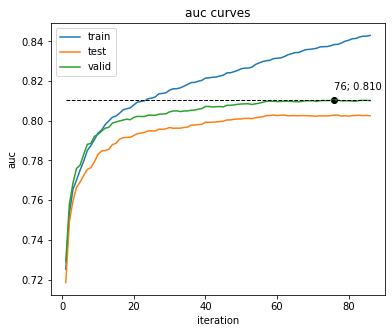

In [40]:
metric = 'auc'

fig = plt.figure(figsize=(6,5))
total_iteration_count = len(evals_result[list(evals_result.keys())[0]][metric])
for sample, vals in evals_result.items():
    plt.plot(
        range(1, total_iteration_count + 1), 
        vals[metric],
        label=sample
    )

best_score = booster.best_score
best_iteration = booster.best_iteration+1

plt.plot([1, total_iteration_count], [best_score, best_score], color='black', ls='--', lw=1)
plt.scatter([best_iteration], [best_score], color = 'black')
plt.annotate(
    '{:d}; {:0.3f}'.format(best_iteration, best_score), 
    xy = (best_iteration, best_score), 
    xytext = (best_iteration,best_score+0.005),
#     textcoords = 'offset points'
)
plt.xlabel('iteration')
plt.ylabel(metric)
plt.legend(loc='best')
plt.title(f'{metric} curves')
plt.show()

In [41]:
#procento neznamych hodnot v jednotlivych promennych
percent_nan_in_each_col = (data.isna().sum()/(len(data))*100)
print(percent_nan_in_each_col)
print(np.sort(percent_nan_in_each_col))

no_of_adults                            13.574857
no_of_children                          84.554885
no_of_weekend_nights                    76.312123
no_of_week_nights                       25.626258
type_of_meal_plan                       49.326521
required_car_parking_space              45.273262
room_type_reserved                      65.183465
lead_time                               78.783093
arrival_year                             9.180988
arrival_month                            2.774423
arrival_date                            83.303917
market_segment_type                     43.229602
repeated_guest                          76.528874
no_of_previous_cancellations             0.213655
no_of_previous_bookings_not_canceled    44.790215
avg_price_per_room                      72.237188
no_of_special_requests                  22.799195
booking_status                           0.000000
sample                                   0.000000
MTE_type_of_meal_plan                   49.326521


                               predictor   strength
0                           arrival_year  38.512684
1                 no_of_special_requests  25.756702
2                MTE_market_segment_type  21.732725
3                      MTE_arrival_month  17.887770
4                              lead_time  15.675954
5                           no_of_adults   9.960219
6   no_of_previous_bookings_not_canceled   9.710450
7                  MTE_type_of_meal_plan   8.503808
8             required_car_parking_space   7.879529
9                      no_of_week_nights   7.831689
10                    avg_price_per_room   6.477319
11                  no_of_weekend_nights   5.486251
12                MTE_room_type_reserved   4.402821
13                        repeated_guest   4.001033
14                        no_of_children   3.842909
15                          arrival_date   3.390364
16          no_of_previous_cancellations   2.638612


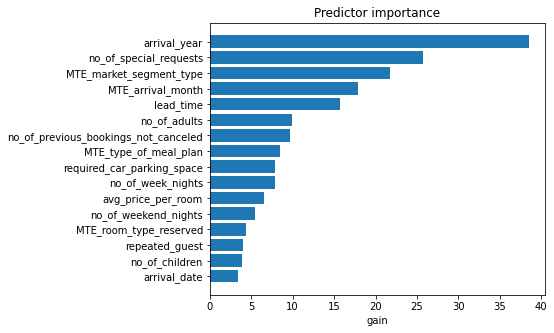

In [42]:
#vyznam jednotlivych promennych v modelu
importance_type = 'gain'

predictor_strength = sorted([(k, v) for k,v in booster.get_score(importance_type = importance_type).items()], key = lambda x: x[1], reverse = True)
predictor_strength = pd.DataFrame(predictor_strength, columns = ['predictor', 'strength'])
fig = plt.figure(figsize=(6,5))
print(predictor_strength)
n_strongest = 16
plt.barh(range(n_strongest, 0, -1), predictor_strength['strength'].iloc[0:16])
plt.yticks(range(n_strongest, 0, -1), predictor_strength['predictor'].iloc[0:16])
plt.xlabel(importance_type)
plt.title('Predictor importance')
plt.show()

Arrival date je blbost a ma maly vliv ,tak ho muzu vyhodt.

Number of children,repeated guest,no_of_weekend_nights, a room type reserved ma hodne unavailable a ma maly vliv, tak je vyhodime

S otaznikem zustava avg_price_per_room, MTE_type_of_meal_plan, required_car_parking_space, no_of_previous_bookings_not_canceled 

nizky vliv ma take no_of_previous_cancellations - asi proto, ze tam jsou vsechny pozorovani skoro stejny, tka to klidne muzu vyhodit, ale tim spis nechat no of previous not canceled.

no_of_previous cancelations ma fakt malo NAN a je docela uzitecne. mohlo by se pouzit pro stratifikaci. jenze ma taky skoro vzdy odpoved 0, takze zas tak zajimavy neni.

# Search for the best model

In this part we generate the predictions on the test set with different parameters and we look for the best results. The outocme of this part is in the csv

In [43]:
#uprava uvazovanych promennych

to_remove = ["arrival_date","no_of_children","repeated_guest","MTE_room_type_reserved"]
questionable = ["avg_price_per_room","MTE_type_of_meal_plan","required_car_parking_space","no_of_previous_bookings_not_canceled"]

In [44]:
#uvazovane parametry pro model
#budeme zkouset ruzne kombinace parametru eta, max_depth a lambda a zarazeni ci nezarazeni questionable promennych

params_gs = {
    'eta': [0.05, 0.1, 0.3, 0.4],
    'max_depth': [3, 4, 5],
    'lambda': [0, 0.1,10]
}

# create all combinations of parameters
param_combinations = list(product(*params_gs.values()))

# create a DataFrame with the parameter combinations
param_df = pd.DataFrame(param_combinations, columns=params_gs.keys())

# print the DataFrame
print(param_df)


     eta  max_depth  lambda
0   0.05          3     0.0
1   0.05          3     0.1
2   0.05          3    10.0
3   0.05          4     0.0
4   0.05          4     0.1
5   0.05          4    10.0
6   0.05          5     0.0
7   0.05          5     0.1
8   0.05          5    10.0
9   0.10          3     0.0
10  0.10          3     0.1
11  0.10          3    10.0
12  0.10          4     0.0
13  0.10          4     0.1
14  0.10          4    10.0
15  0.10          5     0.0
16  0.10          5     0.1
17  0.10          5    10.0
18  0.30          3     0.0
19  0.30          3     0.1
20  0.30          3    10.0
21  0.30          4     0.0
22  0.30          4     0.1
23  0.30          4    10.0
24  0.30          5     0.0
25  0.30          5     0.1
26  0.30          5    10.0
27  0.40          3     0.0
28  0.40          3     0.1
29  0.40          3    10.0
30  0.40          4     0.0
31  0.40          4     0.1
32  0.40          4    10.0
33  0.40          5     0.0
34  0.40          5 

In [45]:
#definice podmnozin promennych, ktere budeme zkouset vyhodit

to_remove = ["arrival_date","no_of_children","repeated_guest","MTE_room_type_reserved"]
questionable = ["avg_price_per_room","MTE_type_of_meal_plan","required_car_parking_space","no_of_previous_bookings_not_canceled"]
rm_1 = ["avg_price_per_room","MTE_type_of_meal_plan"]
rm_2 = ["MTE_type_of_meal_plan","required_car_parking_space"]
rm_3 = ["MTE_type_of_meal_plan","required_car_parking_space","no_of_previous_bookings_not_canceled"]
rm_4 = ["avg_price_per_room","MTE_type_of_meal_plan","required_car_parking_space"]
rm_5 = ["MTE_type_of_meal_plan","required_car_parking_space","no_of_previous_bookings_not_canceled",'no_of_previous_cancellations']




aaa = cols_pred
bbb = [x for x in cols_pred if x not in to_remove]
ccc = [x for x in bbb if x not in questionable]
ddd = [x for x in bbb if x not in rm_1]
eee = [x for x in bbb if x not in rm_2]
fff = [x for x in bbb if x not in rm_3]
ggg = [x for x in bbb if x not in rm_4]

eee = [x for x in bbb if x not in rm_5]

predictor_set_list = [aaa,bbb,ccc,ddd,eee,fff,ggg,eee]


In [53]:
#cely dlouhy grid search pres promenne a parametry


# Initialize the first row and first column values
first_row = list(range(0, 36))
first_col = list(range(3, 7))

# Create an empty data frame with the given row and column labels
#df = pd.DataFrame(index=first_col, columns=first_row)

# Fill the data frame with the product of the row and column values
for row in first_col:
    for col in first_row:
        list_of_results=[]
        for i in range(5):
            ETA = param_df.iloc[col, 0]
            max_depth = param_df.iloc[col, 1]
            MY_lambda = param_df.iloc[col, 2]

            predictor_set = predictor_set_list[row]
            for i in range (4):
                #kdybychom chteli stratifikovat podle neceho dalsiho, museli bychom zlikvidovat unavailable data, coz je skoda. zaroven stratifikace podle booking status asi trochu pomaha - soude z grafu nize
                data_train, data_rest = train_test_split(data, test_size=0.4, random_state = i,stratify = (data[["booking_status"]]))
                data.loc[data_train.index, 'sample'] = 'train'
                # use train_test_split to split the rest into valid and test (don't forget seed); use stratification
                data_valid, data_test = train_test_split(data_rest, test_size=0.5, random_state = i, stratify = (data_rest[["booking_status"]]))
                data.loc[data_valid.index, 'sample'] = 'valid'
                data.loc[data_test.index, 'sample'] = 'test'



                train_mask = (data['sample'] == 'train')
                valid_mask = (data['sample'] == 'valid')
                test_mask = (data['sample'] == 'test')
  #-------------------------------------------------------------------------------------------------------------------      
        
                # set best parameters to be used in XGBoost
                params = {    
                    'max_depth': max_depth,
                    'eta': ETA,
                    'lambda': MY_lambda,
                    "subsample":0.7,
                    'objective': 'binary:logistic',
                    'eval_metric': 'auc',
                    "verbose_eval": 'false'
                }


                evals_result = {}
                booster = xgb.train(
                    verbose_eval=False,
                    params = params,
                    dtrain = xgb.DMatrix(data[train_mask][predictor_set], data[train_mask][col_target]),
                    num_boost_round = 200,
                    evals = (
                        (xgb.DMatrix(data[train_mask][predictor_set], data[train_mask][col_target]), 'train'),
                        (xgb.DMatrix(data[test_mask][predictor_set], data[test_mask][col_target]), 'test'),
                        (xgb.DMatrix(data[valid_mask][predictor_set], data[valid_mask][col_target]), 'valid')
                    ),
                    evals_result = evals_result,
                    early_stopping_rounds = 10
                )


                dtest = xgb.DMatrix(data[valid_mask][predictor_set])
                y_pred = booster.predict(dtest)
                y_true = data[valid_mask][col_target]
                y_true = y_true.values
                roc_auc = roc_auc_score( y_true,y_pred)

                AUC = roc_auc



      
 #-------------------------------------------------------------------------------------------------------------------       
            
            list_of_results.append(AUC)
            
            average = sum(list_of_results) / len(list_of_results)
            var_res = math.sqrt(sum((xi - average) ** 2 for xi in list_of_results) / len(list_of_results))

            result = str(average) + "(" + str(var_res) + ")"
            df.at[row, col] = result
            print(df)
            df.to_csv('/Users/pavelrezabek/Desktop/data-science-2-HA_1/data-science-2-HA_1/output/DF.csv')


print(df)

[08:37:21] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:37:24] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:37:28] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:37:31] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[08:37:45] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:37:48] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:37:51] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:37:54] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[08:38:12] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:38:15] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:38:18] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:38:21] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[08:38:38] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:38:41] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:38:44] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:38:46] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[08:39:01] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:39:04] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:39:07] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:39:10] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[08:39:26] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:39:30] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:39:33] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:39:36] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[08:39:51] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:39:53] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:39:56] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:39:59] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[08:40:13] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:40:18] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:40:21] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:40:26] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[08:40:45] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:40:49] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:40:53] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:40:56] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[08:41:16] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:41:19] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:41:22] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:41:26] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[08:41:41] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:41:45] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:41:48] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:41:51] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[08:42:06] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:42:10] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:42:12] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:42:15] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[08:42:32] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:42:35] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:42:38] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:42:41] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[08:42:57] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:43:01] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:43:04] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:43:07] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[08:43:24] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:43:27] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:43:30] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:43:33] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[08:43:49] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:43:53] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:43:57] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:44:00] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[08:44:18] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:44:21] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:44:24] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:44:28] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[08:44:45] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:44:48] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:44:51] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:44:54] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[08:45:13] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:45:17] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:45:20] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:45:24] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[08:45:41] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:45:44] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:45:47] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:45:51] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[08:46:07] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:46:10] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:46:14] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:46:17] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[08:46:35] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:46:38] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:46:41] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:46:45] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[08:47:03] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:47:10] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:47:14] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:47:18] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[08:47:36] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:47:38] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:47:42] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:47:46] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[08:48:01] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:48:03] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:48:06] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:48:10] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[08:48:25] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:48:27] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:48:30] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:48:33] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[08:48:49] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:48:53] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:48:57] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:48:59] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[08:49:15] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:49:17] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:49:21] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:49:23] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[08:49:38] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:49:41] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:49:45] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:49:48] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[08:50:04] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:50:07] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:50:10] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:50:13] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[08:50:28] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:50:31] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:50:34] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:50:37] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[08:50:53] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:50:56] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:50:59] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:51:02] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[08:51:18] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:51:21] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:51:24] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:51:31] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[08:51:46] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:51:49] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:51:52] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:51:54] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[08:52:08] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:52:11] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:52:14] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:52:16] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[08:52:31] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:52:35] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:52:38] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:52:41] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[08:52:58] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:53:02] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:53:04] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:53:07] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[08:53:23] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:53:26] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:53:29] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:53:32] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[08:53:45] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:53:47] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:53:49] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:53:52] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[08:54:02] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:54:04] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:54:06] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:54:09] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[08:54:21] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:54:24] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:54:28] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:54:30] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[08:54:43] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:54:45] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:54:48] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:54:51] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[08:55:06] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:55:10] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:55:13] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:55:15] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[08:55:29] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:55:32] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:55:34] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:55:36] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[08:55:49] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:55:52] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:55:54] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:55:56] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[08:56:11] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:56:12] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:56:14] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:56:16] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[08:56:24] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:56:25] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:56:27] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:56:29] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[08:56:37] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:56:39] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:56:40] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:56:42] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[08:56:51] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:56:53] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:56:54] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:56:56] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[08:57:04] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:57:06] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:57:07] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:57:09] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[08:57:17] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:57:18] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:57:20] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:57:22] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[08:57:32] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:57:34] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:57:36] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:57:38] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[08:57:48] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:57:50] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:57:53] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:57:55] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[08:58:03] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:58:04] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:58:05] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:58:07] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[08:58:13] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:58:14] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:58:15] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:58:16] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[08:58:23] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:58:24] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:58:26] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:58:27] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[08:58:33] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:58:34] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:58:35] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:58:37] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[08:58:42] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:58:44] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:58:45] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:58:47] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[08:58:52] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:58:53] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:58:54] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:58:55] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[08:59:01] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:59:02] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:59:03] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:59:04] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[08:59:10] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:59:11] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:59:12] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:59:13] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[08:59:18] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:59:19] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:59:20] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:59:22] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[08:59:27] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:59:28] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:59:29] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:59:30] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[08:59:35] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:59:36] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:59:38] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:59:39] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[08:59:44] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:59:46] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:59:47] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:59:48] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[08:59:54] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:59:55] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:59:56] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[08:59:57] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:00:04] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:00:05] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:00:06] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:00:07] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:00:15] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:00:16] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:00:17] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:00:19] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:00:24] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:00:25] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:00:26] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:00:28] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:00:35] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:00:37] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:00:38] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:00:40] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:00:46] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:00:47] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:00:48] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:00:49] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:00:56] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:00:57] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:00:58] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:00:59] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:01:07] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:01:09] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:01:10] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:01:11] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:01:19] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:01:20] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:01:21] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:01:22] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:01:29] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:01:30] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:01:31] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:01:33] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:01:40] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:01:41] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:01:42] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:01:44] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:01:50] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:01:51] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:01:52] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:01:53] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:01:58] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:01:59] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:02:01] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:02:02] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:02:08] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:02:09] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:02:10] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:02:11] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:02:17] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:02:18] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:02:20] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:02:21] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:02:27] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:02:28] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:02:30] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:02:31] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:02:38] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:02:39] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:02:41] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:02:42] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:02:50] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:02:51] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:02:52] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:02:54] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:03:00] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:03:01] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:03:01] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:03:02] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:03:07] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:03:08] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:03:08] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:03:09] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:03:14] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:03:15] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:03:16] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:03:17] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:03:22] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:03:23] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:03:24] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:03:25] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:03:30] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:03:31] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:03:33] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:03:34] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:03:40] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:03:41] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:03:42] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:03:44] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:03:50] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:03:51] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:03:52] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:03:53] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:03:59] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:04:03] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:04:06] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:04:09] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:04:25] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:04:28] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:04:31] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:04:35] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:04:53] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:04:55] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:04:58] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:05:01] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:05:16] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:05:19] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:05:22] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:05:25] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:05:42] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:05:45] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:05:48] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:05:51] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:06:06] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:06:09] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:06:12] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:06:15] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:06:30] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:06:33] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:06:36] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:06:39] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:06:56] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:07:01] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:07:05] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:07:08] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:07:24] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:07:27] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:07:31] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:07:34] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:07:50] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:07:53] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:07:56] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:07:59] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:08:16] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:08:20] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:08:23] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:08:26] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:08:44] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:08:48] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:08:52] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:08:55] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:09:12] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:09:16] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:09:20] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:09:23] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:09:39] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:09:42] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:09:45] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:09:48] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:10:03] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:10:06] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:10:09] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:10:12] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:10:28] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:10:32] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:10:35] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:10:38] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:10:56] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:11:00] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:11:04] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:11:08] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:11:29] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:11:33] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:11:37] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:11:40] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:12:00] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:12:04] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:12:09] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:12:14] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:12:34] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:12:38] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:12:42] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:12:46] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:13:07] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:13:11] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:13:15] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:13:19] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:13:38] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:13:42] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:13:45] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:13:49] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:14:07] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:14:11] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:14:15] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:14:19] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:14:34] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:14:36] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:14:40] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:14:43] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:14:57] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:14:59] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:15:02] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:15:06] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:15:20] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:15:23] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:15:26] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:15:29] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:15:43] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:15:46] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:15:49] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:15:54] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:16:09] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:16:12] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:16:17] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:16:20] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:16:34] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:16:37] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:16:40] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:16:42] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:16:59] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:17:02] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:17:07] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:17:10] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:17:25] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:17:28] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:17:31] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:17:34] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:17:50] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:17:53] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:17:55] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:17:58] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:18:14] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:18:16] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:18:19] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:18:23] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:18:42] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:18:46] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:18:50] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:18:54] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:19:10] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:19:13] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:19:16] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:19:20] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:19:36] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:19:39] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:19:42] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:19:46] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:20:04] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:20:07] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:20:10] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:20:16] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:20:33] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:20:37] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:20:40] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:20:43] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:20:58] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:21:01] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:21:05] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:21:07] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:21:22] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:21:24] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:21:28] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:21:29] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:21:44] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:21:47] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:21:50] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:21:52] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:22:10] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:22:13] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:22:15] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:22:18] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:22:33] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:22:36] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:22:39] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:22:41] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:22:57] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:23:00] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:23:03] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:23:06] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:23:23] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:23:26] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:23:29] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:23:32] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:23:48] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:23:49] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:23:51] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:23:53] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:24:01] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:24:02] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:24:04] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:24:05] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:24:13] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:24:15] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:24:17] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:24:18] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:24:27] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:24:28] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:24:31] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:24:33] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:24:43] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:24:44] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:24:47] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:24:49] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:24:59] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:25:01] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:25:03] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:25:05] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:25:14] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:25:16] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:25:17] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:25:19] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:25:29] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:25:32] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:25:34] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:25:35] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:25:45] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:25:46] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:25:48] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:25:50] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:26:04] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:26:06] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:26:08] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:26:11] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:26:22] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:26:23] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:26:25] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:26:27] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:26:34] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:26:36] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:26:37] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:26:39] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:26:45] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:26:47] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:26:48] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:26:50] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:26:59] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:27:02] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:27:03] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:27:05] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:27:16] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:27:18] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:27:19] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:27:22] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:27:32] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:27:33] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:27:34] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:27:35] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:27:41] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:27:43] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:27:44] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:27:45] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:27:53] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:27:54] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:27:55] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:27:56] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:28:03] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:28:04] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:28:05] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:28:06] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:28:13] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:28:14] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:28:15] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:28:16] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:28:24] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:28:25] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:28:27] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:28:29] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:28:39] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:28:40] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:28:42] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:28:44] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:28:53] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:28:55] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:28:57] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:28:59] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:29:06] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:29:07] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:29:09] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:29:10] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:29:18] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:29:20] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:29:23] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:29:25] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:29:32] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:29:33] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:29:35] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:29:36] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:29:43] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:29:44] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:29:45] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:29:46] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:29:53] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:29:54] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:29:56] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:29:57] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:30:03] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:30:05] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:30:06] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:30:08] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:30:16] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:30:17] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:30:18] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:30:19] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:30:27] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:30:28] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:30:29] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:30:30] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:30:37] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:30:37] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:30:39] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:30:40] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:30:46] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:30:46] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:30:48] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:30:49] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:30:55] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:30:56] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:30:57] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:30:58] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:31:04] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:31:05] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:31:06] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:31:07] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:31:13] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:31:15] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:31:16] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:31:17] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:31:25] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:31:26] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:31:28] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:31:29] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:31:36] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:31:37] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:31:39] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:31:40] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:31:48] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:31:49] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:31:50] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:31:51] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:31:56] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:31:57] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:31:58] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:31:59] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:32:04] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:32:05] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:32:06] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:32:07] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:32:12] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:32:13] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:32:14] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:32:15] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:32:21] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:32:22] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:32:23] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:32:24] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:32:30] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:32:31] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:32:32] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:32:33] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:32:39] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:32:40] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:32:41] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:32:42] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:32:48] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:32:51] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:32:54] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:32:56] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:33:10] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:33:13] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:33:15] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:33:18] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                                          0                        1   \
0                    0.7969741086902429(0.0)  0.7969401129770858(0.0)   
1                    0.7971874686235393(0.0)  0.7966196911028363(0.0)   
2                    

[09:33:32] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:33:35] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:33:38] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:33:40] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:33:54] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:33:57] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:34:00] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:34:03] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:34:19] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:34:23] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:34:26] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:34:29] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:34:44] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:34:47] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:34:49] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:34:52] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:35:05] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:35:09] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:35:11] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:35:14] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   
2  0.7896128635849707(0.0)   0.789578758736298(0.0)   
3  0.790558086286904

[09:35:27] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:35:30] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:35:33] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:35:35] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:35:49] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:35:52] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:35:55] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:35:58] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:36:12] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:36:15] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:36:18] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:36:21] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:36:35] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:36:38] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:36:40] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:36:43] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:36:57] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:37:00] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:37:03] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:37:06] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:37:21] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:37:23] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:37:26] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:37:29] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:37:44] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:37:47] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:37:50] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:37:53] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:38:07] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:38:10] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:38:13] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:38:15] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:38:31] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:38:35] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:38:38] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:39:16] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[09:39:44] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:56:28] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[09:56:31] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:11:52] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:12:26] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:12:33] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:12:37] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:12:41] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:12:57] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:13:01] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:13:04] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:13:07] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:13:25] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:13:28] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:13:31] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:13:35] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:13:53] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:13:57] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:14:00] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:14:03] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:14:22] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:14:26] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:14:29] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:14:33] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:14:49] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:14:52] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:14:56] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:14:59] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:15:13] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:15:15] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:15:18] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:15:21] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:15:34] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:15:37] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:15:41] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:15:45] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:16:01] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:16:03] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:16:06] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:16:09] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:16:22] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:16:25] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:16:28] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:16:31] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:16:45] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:16:48] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:16:51] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:16:54] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:17:08] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:17:10] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:17:14] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:17:17] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:17:32] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:17:36] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:17:41] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:17:45] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:18:01] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:18:04] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:18:06] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:18:09] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:18:23] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:18:28] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:18:31] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:18:34] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:18:48] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:18:52] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:18:57] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:18:59] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:19:15] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:19:18] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:19:21] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:19:23] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:19:38] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:19:41] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:19:43] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:19:46] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:20:00] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:20:03] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:20:06] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:20:09] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:20:28] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:20:32] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:20:35] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:20:38] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:20:55] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:21:00] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:21:03] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:21:06] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:21:19] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:21:22] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:21:25] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:21:27] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:21:40] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:21:43] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:21:45] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:21:49] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:22:05] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:22:08] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:22:12] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:22:15] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:22:30] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:22:33] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:22:35] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:22:37] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:22:52] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:22:55] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:22:57] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:22:59] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:23:14] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:23:18] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:23:21] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:23:24] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:23:43] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:23:46] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:23:48] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:23:51] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:24:09] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:24:11] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:24:12] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:24:14] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:24:24] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:24:27] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:24:28] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:24:30] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:24:39] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:24:40] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:24:42] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:24:43] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:24:52] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:24:54] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:24:57] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:24:58] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:25:07] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:25:08] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:25:11] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:25:13] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:25:24] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:25:25] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:25:27] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:25:30] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:25:40] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:25:42] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:25:43] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:25:46] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:25:56] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:25:57] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:25:59] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:26:01] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:26:09] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:26:10] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:26:12] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:26:13] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:26:20] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:26:21] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:26:23] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:26:24] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:26:31] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:26:32] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:26:34] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:26:35] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:26:41] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:26:42] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:26:44] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:26:45] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:26:52] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:26:53] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:26:55] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:26:56] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:27:05] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:27:06] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:27:08] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:27:10] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:27:19] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:27:20] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:27:22] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:27:24] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:27:32] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:27:33] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:27:34] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:27:36] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:27:41] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:27:42] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:27:43] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:27:45] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:27:50] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:27:51] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:27:53] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:27:54] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:27:59] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:28:01] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:28:02] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:28:03] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:28:08] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:28:09] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:28:10] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:28:11] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:28:17] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:28:18] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:28:20] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:28:22] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:28:33] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:28:34] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:28:36] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:28:37] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:28:45] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:28:47] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:28:48] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:28:50] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:28:57] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:28:58] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:29:00] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:29:00] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:29:07] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:29:08] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:29:10] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:29:11] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:29:18] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:29:19] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:29:20] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:29:21] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:29:28] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:29:29] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:29:31] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:29:32] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:29:38] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:29:39] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:29:41] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:29:42] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:29:50] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:29:52] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:29:54] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:29:56] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:30:04] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:30:05] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:30:07] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:30:09] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:30:18] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:30:18] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:30:19] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:30:20] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:30:25] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:30:26] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:30:27] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:30:28] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:30:32] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:30:33] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:30:34] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:30:35] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:30:40] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:30:41] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:30:42] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:30:43] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:30:48] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:30:49] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:30:50] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:30:51] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:30:56] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:30:58] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:30:59] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:31:01] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:31:08] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:31:09] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:31:10] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:31:12] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:31:19] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:31:20] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:31:22] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:31:23] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:31:28] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:31:29] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:31:30] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:31:31] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:31:36] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:31:37] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:31:38] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:31:38] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:31:43] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:31:44] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:31:45] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:31:46] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:31:51] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:31:52] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:31:53] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:31:54] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:32:00] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:32:01] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:32:02] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:32:03] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:32:09] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:32:10] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:32:12] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:32:13] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:32:20] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:32:23] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:32:24] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:32:26] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:32:32] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:32:34] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:32:37] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:32:40] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:32:54] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:32:57] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:32:59] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:33:02] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:33:18] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:33:21] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:33:23] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:33:26] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:33:43] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:33:46] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:33:48] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:33:52] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:34:06] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:34:09] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:34:11] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:34:14] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:34:28] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:34:30] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:34:33] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:34:35] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:34:48] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:34:51] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:34:53] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:34:56] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   
2  0.7896128635849707(0.0)   0.789578758736298(0.0)   
3  0.790558086286904

[10:35:08] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:35:11] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:35:13] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:35:16] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:35:29] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:35:32] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:35:35] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:35:38] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:35:53] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:35:56] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:35:59] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:36:02] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:36:20] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:36:23] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:36:26] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:36:29] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:36:43] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:36:46] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:36:49] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:36:52] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:37:06] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:37:09] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:37:12] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:37:15] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:37:30] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:37:33] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:37:36] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:37:38] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:37:52] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:37:55] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:37:58] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:38:01] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:38:16] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:38:19] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:38:22] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:38:25] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:38:41] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:38:44] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:38:46] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:38:50] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:39:05] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:39:08] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:39:11] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:39:14] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:39:37] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:39:41] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:39:45] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:39:48] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:40:06] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:40:09] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:40:13] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:40:16] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:40:32] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:40:36] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:40:39] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:40:42] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:40:59] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:41:02] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:41:05] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:41:09] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:41:25] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:41:28] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:41:31] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:41:35] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:41:48] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:41:50] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:41:53] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:41:57] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:42:12] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:42:14] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:42:17] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:42:20] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:42:35] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:42:37] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:42:39] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:42:42] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:42:54] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:42:56] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:42:58] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:43:00] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:43:14] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:43:16] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:43:18] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:43:21] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:43:34] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:43:37] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:43:39] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:43:42] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:43:57] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:44:01] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:44:03] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:44:06] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:44:19] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:44:21] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:44:23] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:44:25] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:44:35] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:44:37] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:44:39] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:44:41] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:44:51] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:44:53] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:44:56] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:44:58] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:45:09] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:45:11] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:45:13] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:45:15] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:45:26] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:45:28] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:45:30] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:45:32] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:45:44] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:45:47] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:45:49] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:45:51] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:46:05] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:46:08] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:46:11] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:46:14] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:46:29] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:46:33] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:46:35] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:46:38] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:46:51] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:46:53] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:46:55] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:46:57] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:47:07] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:47:09] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:47:11] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:47:14] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:47:24] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:47:26] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:47:28] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:47:31] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:47:41] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:47:43] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:47:45] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:47:48] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:47:59] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:48:01] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:48:04] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:48:06] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:48:16] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:48:18] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:48:20] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:48:23] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:48:36] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:48:38] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:48:40] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:48:43] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:48:54] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:48:55] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:48:56] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:48:57] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:49:03] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:49:05] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:49:06] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:49:07] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:49:13] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:49:14] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:49:15] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:49:16] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:49:23] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:49:25] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:49:26] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:49:28] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:49:35] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:49:37] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:49:38] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:49:39] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:49:47] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:49:49] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:49:50] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:49:52] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:50:00] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:50:02] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:50:03] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:50:04] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:50:11] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:50:12] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:50:13] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:50:15] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:50:20] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:50:21] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:50:22] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:50:23] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:50:28] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:50:29] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:50:30] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:50:31] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:50:35] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:50:37] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:50:38] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:50:39] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:50:46] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:50:47] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:50:49] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:50:50] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:50:58] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:50:59] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:51:00] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:51:02] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:51:09] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:51:10] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:51:11] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:51:13] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:51:20] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:51:22] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:51:23] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:51:25] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:51:31] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:51:32] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:51:32] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:51:34] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:51:39] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:51:40] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:51:41] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:51:42] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:51:47] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:51:49] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:51:50] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:51:51] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:51:56] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:51:57] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:51:58] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:51:59] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:52:05] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:52:06] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:52:08] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:52:09] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:52:16] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:52:17] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:52:19] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:52:20] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:52:26] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:52:28] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:52:29] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:52:30] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:52:37] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:52:38] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:52:39] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:52:40] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:52:46] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:52:48] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:52:49] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:52:50] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:52:56] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:52:58] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:52:59] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:53:00] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:53:06] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:53:07] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:53:08] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:53:09] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:53:15] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:53:16] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:53:17] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:53:18] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:53:24] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:53:25] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:53:26] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:53:27] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:53:33] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:53:34] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:53:35] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:53:37] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:53:43] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:53:44] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:53:45] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:53:47] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:53:53] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:53:54] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:53:55] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:53:56] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:54:02] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:54:03] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:54:04] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:54:05] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:54:11] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:54:12] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:54:13] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:54:14] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:54:19] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:54:20] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:54:21] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:54:22] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:54:26] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:54:27] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:54:27] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:54:28] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:54:33] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:54:34] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:54:35] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:54:36] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:54:42] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:54:43] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:54:44] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:54:45] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:54:50] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:54:51] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:54:52] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:54:53] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:54:58] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:54:59] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:54:59] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:55:00] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:55:05] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:55:06] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:55:06] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:55:07] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:55:12] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:55:13] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:55:14] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:55:14] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:55:19] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:55:20] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:55:21] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:55:21] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:55:26] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:55:27] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:55:28] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:55:28] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:55:33] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:55:34] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:55:35] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:55:36] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


[10:55:41] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:55:42] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:55:43] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

[10:55:44] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

                        0                        1                        2   \
0  0.7969741086902429(0.0)  0.7969401129770858(0.0)   0.793614098999009(0.0)   
1  0.7971874686235393(0.0)  0.7966196911028363(0.0)   0.793415581495855(0.0)   


In [54]:
#data = pd.read_csv('2023_DS2_HW1_data_train.csv', sep = ',', decimal = '.', index_col = 'Booking_ID')

In [57]:
#na zaklade grid searche model s druhym nejlepsim AUC, ktery ma ale o hodne min regressoru nez ten s nejlepsim
predictor_set = fff
params = {    
    'max_depth': 5,
    'eta': 0.10,
    'lambda': 0.1,
    "subsample":0.7,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    "verbose_eval": 'false'
}


evals_result = {}
booster = xgb.train(
    verbose_eval=False,
    params = params,
    dtrain = xgb.DMatrix(data[train_mask][predictor_set], data[train_mask][col_target]),
    num_boost_round = 200,
    evals = (
        (xgb.DMatrix(data[train_mask][predictor_set], data[train_mask][col_target]), 'train'),
        (xgb.DMatrix(data[test_mask][predictor_set], data[test_mask][col_target]), 'test'),
        (xgb.DMatrix(data[valid_mask][predictor_set], data[valid_mask][col_target]), 'valid')
    ),
    evals_result = evals_result,
    early_stopping_rounds = 10
)


dtest = xgb.DMatrix(data[valid_mask][predictor_set])
y_pred = booster.predict(dtest)
y_true = data[valid_mask][col_target]
y_true = y_true.values
roc_auc = roc_auc_score( y_true,y_pred)

AUC = roc_auc
print(AUC)


[23:03:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { verbose_eval } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


0.8099511945973554


In [47]:
data['no_of_previous_cancellations']

Booking_ID
INN10204    0.0
INN20020    0.0
INN16435    0.0
INN07143    0.0
INN20511    0.0
           ... 
INN16851    0.0
INN06266    0.0
INN11285    0.0
INN00861    0.0
INN15796    0.0
Name: no_of_previous_cancellations, Length: 32295, dtype: float64

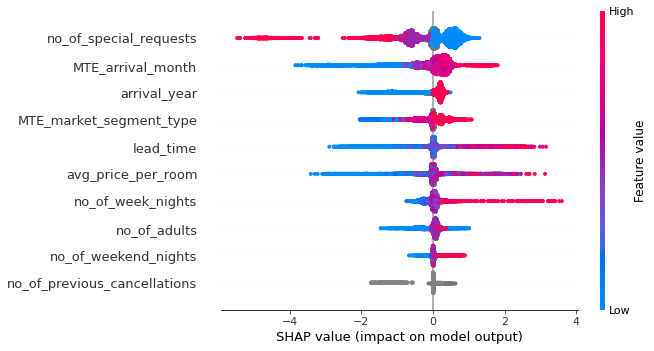

In [33]:
#SHAP hodnoty
shap.initjs()
explainer = shap.TreeExplainer(booster)
shap_values = explainer.shap_values(data[predictor_set])
plt.figure()
shap.summary_plot(shap_values, data[predictor_set],show=True)
plt.show()

Vsechny vychazi dost logicky. Napriklad cim vic special requastu, tim spis to pak uz nezrusili. Cim vyssi lead time - cim vic dopredu to objednali, tim vetsi sance, ze to jeste zrusili.

Number of adults se chova na prvni pohled trochu zvlastne, protoze nizke hodnoty zpusobuji hodne i malo ruseni. Jak je ale videt z partial dependency plot nize, je to tim, ze ve skutecnosti s rostoucim poctem dospelych (takze asi obvykle rostouci velikosti skupiny) byla vetsi pravdepodobnost zruseni, coz smysl dava. Specificky se pak chovaji skupiny, kde dospeli nebyli zadni, coz byl zrejme uplne jiny typ skupin a dva smysl, ze se choval jinak

Number of previous cancellations je sede, i kdyz nemam moc NaN. Nicmene dle partial dependence plotu - cim vic minulych zruseni, tim mensi sance na dalsi zruseni. To je trochu prekvapive. Obecne number of previous cancellations ma skoro vsechna pozorovani stejne = 0. Presto prekvapive gain z tohoto variablu neni uplne nejnizsi. I tak je otazka, jestli ho radeji nevynechat

In [56]:
data.no_of_previous_cancellations.value_counts(dropna=False)

0.0     31919
1.0       182
NaN        69
2.0        42
3.0        37
11.0       22
5.0        10
4.0         9
13.0        4
6.0         1
Name: no_of_previous_cancellations, dtype: int64

In [42]:
def partial_dependency(bst, X, y, feature_names, feature_ids = [], f_id = -1):

    """
    Calculate the dependency (or partial dependency) of a response variable on a predictor (or multiple predictors)
    1. Sample a grid of values of a predictor.
    2. For each value, replace every row of that predictor with this value, calculate the average prediction.
    """
    X_temp = X.copy()
    grid = np.linspace(
        np.percentile(X_temp[:, f_id], 0.1),
        np.percentile(X_temp[:, f_id], 99.5),
        50
    )
    y_pred = np.zeros(len(grid))

    if len(feature_ids) == 0 or f_id == -1:
        print ('Input error!')
        return
    else:
        for i, val in enumerate(grid):

            X_temp[:, f_id] = val
            data = xgb.DMatrix(X_temp, feature_names = feature_names)

            y_pred[i] = np.average(bst.predict(data))

    return grid, y_pred

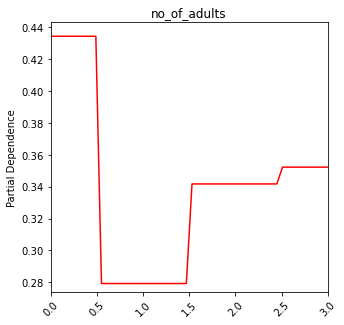

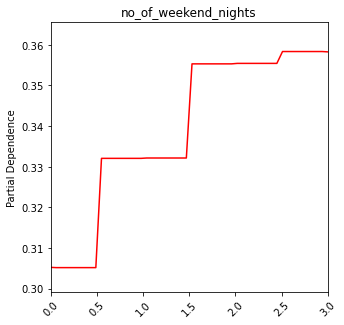

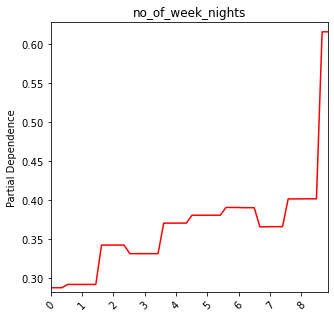

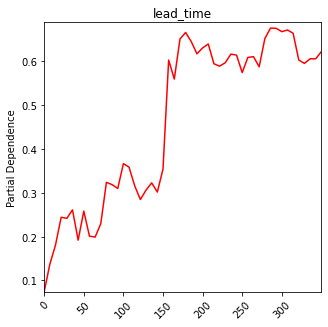

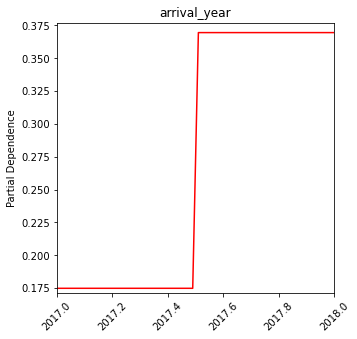

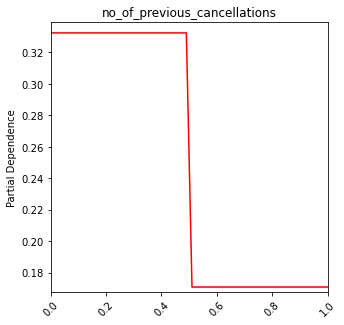

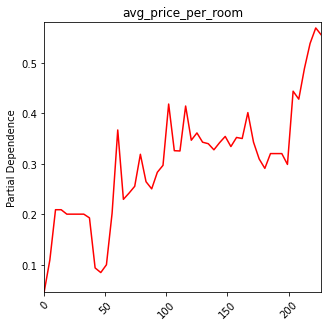

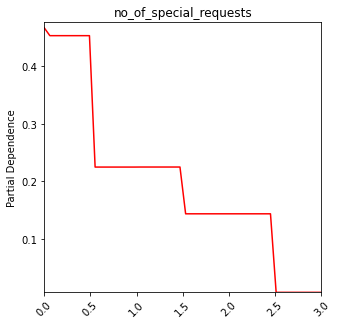

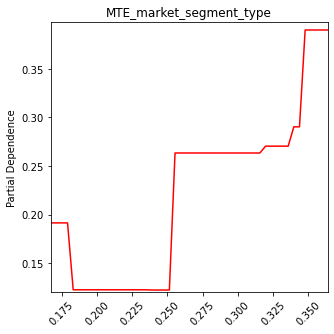

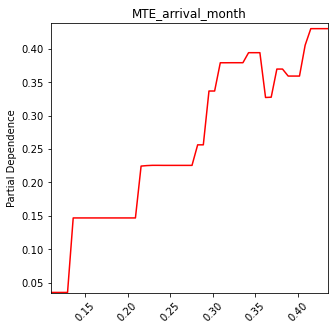

In [55]:
lst_f =  predictor_set
sampled_data = data.sample(frac=0.1, random_state=12)
for f in lst_f:
    f_id = predictor_set.index(f)
    feature_ids = range(len(predictor_set))

    mask = sampled_data[f].notnull()
    grid, y_pred = partial_dependency(
        booster,
        sampled_data[mask][predictor_set].values,
        sampled_data[mask][col_target].values,
        feature_names = predictor_set,
        feature_ids = feature_ids,
        f_id = f_id
    )

    fig, ax = plt.subplots()
    fig.set_size_inches(5, 5)
    plt.subplots_adjust(left = 0.17, right = 0.94, bottom = 0.15, top = 0.9)

    ax.plot(grid, y_pred, ls = '-', color = 'red', linewidth = 1.5, label='fit')

    ax.set_xlim(min(grid), max(grid))
    ax.set_ylim(0.98 * min(y_pred), 1.02 * max(y_pred))

    ax.set_title(f)
    ax.set_ylabel('Partial Dependence')
    plt.xticks(rotation=45)

    plt.show()

In [49]:
#vyznam jednotlivych promennych ve finalnim modelu
importance_type = 'gain'

predictor_strength = sorted([(k, v) for k,v in booster.get_score(importance_type = importance_type).items()], key = lambda x: x[1], reverse = True)
predictor_strength = pd.DataFrame(predictor_strength, columns = ['predictor', 'strength'])
fig = plt.figure(figsize=(6,5))
print(predictor_strength)

                      predictor   strength
0                  arrival_year  19.626223
1        no_of_special_requests  16.525399
2             MTE_arrival_month  10.346971
3       MTE_market_segment_type   9.983667
4                     lead_time   9.227017
5                  no_of_adults   6.322006
6            avg_price_per_room   5.484528
7             no_of_week_nights   5.169292
8  no_of_previous_cancellations   5.139775
9          no_of_weekend_nights   4.786614


<Figure size 432x360 with 0 Axes>

In [60]:
#model bez number of previous cancellations
predictor_set = [x for x in fff if x not in ['no_of_previous_cancellations']]


In [63]:

params = {    
    'max_depth': 5,
    'eta': 0.10,
    'lambda': 0.1,
    "subsample":0.7,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    "verbose_eval": 'false'
}


evals_result = {}
booster = xgb.train(
    verbose_eval=False,
    params = params,
    dtrain = xgb.DMatrix(data[train_mask][predictor_set], data[train_mask][col_target]),
    num_boost_round = 200,
    evals = (
        (xgb.DMatrix(data[train_mask][predictor_set], data[train_mask][col_target]), 'train'),
        (xgb.DMatrix(data[test_mask][predictor_set], data[test_mask][col_target]), 'test'),
        (xgb.DMatrix(data[valid_mask][predictor_set], data[valid_mask][col_target]), 'valid')
    ),
    evals_result = evals_result,
    early_stopping_rounds = 10
)


dtest = xgb.DMatrix(data[valid_mask][predictor_set])
y_pred = booster.predict(dtest)
y_true = data[valid_mask][col_target]
y_true = y_true.values
roc_auc = roc_auc_score( y_true,y_pred)

AUC = roc_auc

print(AUC)

[23:07:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { verbose_eval } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


0.8110247060980561


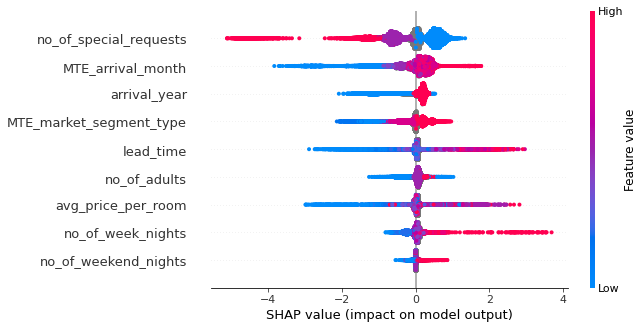

In [64]:
#SHAP hodnoty pro model bez number of previous cancellations
shap.initjs()
explainer = shap.TreeExplainer(booster)
shap_values = explainer.shap_values(data[predictor_set])
plt.figure()
shap.summary_plot(shap_values, data[predictor_set],show=True)
plt.show()

#chova se uz cely pekne, AUC mam spis vyssi, pouziji tenhle model

# Code for getting final predictions


In [10]:
data = pd.read_csv('2023_DS2_HW1_data_test.csv', sep = ',', decimal = '.', index_col = 'Booking_ID')

In [11]:
# define list of predictors
cols_pred = list(data.columns)

# define list of numerical predictors
cols_pred_num = [col for col in cols_pred if data[col].dtype != 'O']
# define list of categorical predictors
cols_pred_cat = [col for col in cols_pred if data[col].dtype == 'O']


In [13]:
cols_pred_num.remove('arrival_month')
cols_pred_cat.append('arrival_month')


In [14]:
#we choose just the prediction variables that we use
cols_pred_cat = cols_pred_cat[2:4]

In [ ]:
#we replace the cat. variables by MTE from train set
replace_dict1 = {'Online': 0.363841, 'Offline': 0.307843, 'Corporate': 0.167078, 'Complementary': 0.19804247576622647,'Aviation': 0.32545989}

# Use the replace() method to replace values in the "name" column
data['market_segment_type'] = data['market_segment_type'].replace(replace_dict1)

replace_dict2 = {1: 0.10975141226859428, 2: 0.2649120016467528, 3: 0.2876456095535222, 4: 0.36802913597831044, 5: 0.36072953496010357, 6: 0.3945629908265532, 7: 0.43479006606457415, 8: 0.3784152206481103, 9: 0.3209463849088696, 10: 0.35476825930811823, 11: 0.29137465229584697, 12: 0.15468658181050565}

# Use the replace() method to replace values in the "name" column
data['arrival_month'] = data['arrival_month'].replace(replace_dict2)





In [ ]:
#We rename the columns
data = data.rename(columns={'arrival_month': 'MTE_arrival_month'})
data = data.rename(columns={'market_segment_type': 'MTE_market_segment_type'})

In [ ]:
dtrain = xgb.DMatrix(data[predictor_set])
y_pred = booster.predict(dtrain)
xxx = pd.DataFrame(y_pred)


xxx.to_csv("/Users/pavelrezabek/Desktop/predictions.csv", header=False, index=False)